In [25]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 68.6 MB 37.2 MB/s eta 0:00:01
  Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
  Using cached filelock-3.18.0-py3-none-any.whl (16 kB)
  Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)
  Using cached fsspec-2025.5.1-py3-none-any.whl (199 kB)
  Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [27]:
pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.9 MB 9.2 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install shap

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 547 kB 7.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.7 MB 57.6 MB/s eta 0:00:01
     |████████████████████████████████| 28.8 MB 64.0 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


MODEL TRAIN

In [7]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [8]:
df = pd.read_csv("aaf_age_labels.csv")

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"Train size: {len(df_train)}, Test size: {len(df_test)}")


Train size: 10657, Test size: 2665


In [9]:
import pandas as pd
import numpy as np
from torch.utils.data import WeightedRandomSampler

df = pd.read_csv("aaf_age_labels.csv")  # image_path, age
df_train = df_train.reset_index(drop=True)

bins = [0, 10, 20, 30, 40, 50, 60, 70, 100]
df_train['age_bin'] = pd.cut(df_train['age'], bins=bins, labels=False)

bin_counts = df_train['age_bin'].value_counts().to_dict()

weights = df_train['age_bin'].apply(lambda x: 1.0 / bin_counts.get(x, 1)).values
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [11]:
class AgeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]['image_path']
        age = self.df.iloc[idx]['age']
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor([age], dtype=torch.float32)


In [13]:
BATCH_SIZE = 8

train_dataset = AgeDataset(df_train, transform=train_transform)
test_dataset = AgeDataset(df_test, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [14]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)  # 회귀 출력
model = model.to(device)


/Users/geko/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/geko/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

EPOCHS = 5

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

metrics_per_epoch = []
best_mae = float('inf')
best_model_path = "best_model.pth"

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for imgs, targets in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}"):
        imgs, targets = imgs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)

    model.eval()
    test_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for imgs, targets in test_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * imgs.size(0)

            all_preds.extend(outputs.view(-1).cpu().numpy())
            all_targets.extend(targets.view(-1).cpu().numpy())


    avg_test_loss = test_loss / len(test_loader.dataset)
    mae_score = mean_absolute_error(all_targets, all_preds)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} / Test Loss = {avg_test_loss:.4f} / MAE = {mae_score:.2f}years")

    mse = mean_squared_error(all_targets, all_preds)
    rmse_score = mse ** 0.5
    r2 = r2_score(all_targets, all_preds)
    
    print(f"/ RMSE = {rmse_score:.2f}years / R² = {r2:.3f}")

    metrics_per_epoch.append({
    'epoch': epoch + 1,
    'train_loss': avg_train_loss,
    'test_loss': avg_test_loss,
    'mae': mae_score,
    'rmse': rmse_score,
    'r2': r2
    })

    if mae_score < best_mae:
        best_mae = mae_score
        torch.save(model.state_dict(), best_model_path)
        print(f"[Epoch {epoch+1}] Best model saved with MAE = {best_mae:.2f}years")

df_metrics = pd.DataFrame(metrics_per_epoch)
df_metrics.to_csv("training_metrics.csv", index=False)

[Train] Epoch 1: 100%|██████████| 1333/1333 [09:17<00:00,  2.39it/s]


Epoch 1: Train Loss = 548.0309 / Test Loss = 79.9729 / MAE = 6.99세
/ RMSE = 8.94세 / R² = 0.727
✅ [Epoch 1] Best model saved with MAE = 6.99세


[Train] Epoch 2: 100%|██████████| 1333/1333 [09:21<00:00,  2.38it/s]


Epoch 2: Train Loss = 82.9325 / Test Loss = 66.3711 / MAE = 6.31세
/ RMSE = 8.15세 / R² = 0.774
✅ [Epoch 2] Best model saved with MAE = 6.31세


[Train] Epoch 3: 100%|██████████| 1333/1333 [09:33<00:00,  2.33it/s]


Epoch 3: Train Loss = 51.9365 / Test Loss = 59.6902 / MAE = 5.95세
/ RMSE = 7.73세 / R² = 0.797
✅ [Epoch 3] Best model saved with MAE = 5.95세


[Train] Epoch 4: 100%|██████████| 1333/1333 [09:19<00:00,  2.38it/s]


Epoch 4: Train Loss = 42.2489 / Test Loss = 64.0037 / MAE = 6.25세
/ RMSE = 8.00세 / R² = 0.782


[Train] Epoch 5: 100%|██████████| 1333/1333 [09:20<00:00,  2.38it/s]


Epoch 5: Train Loss = 36.4105 / Test Loss = 59.5553 / MAE = 6.00세
/ RMSE = 7.72세 / R² = 0.797


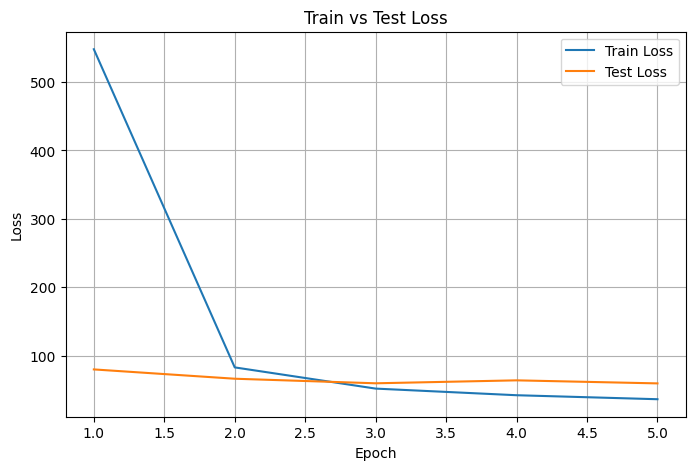

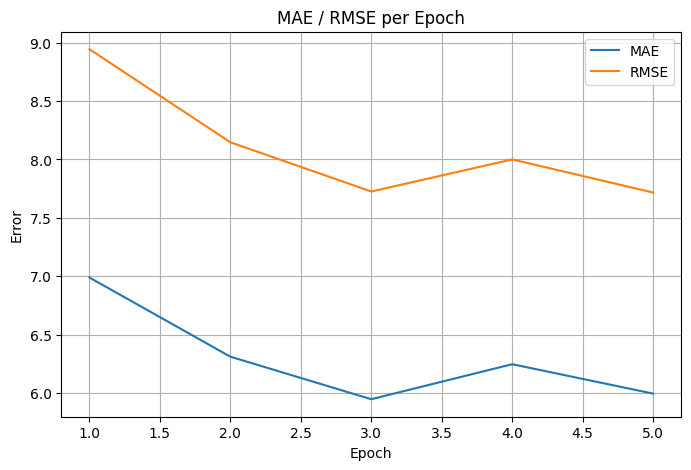

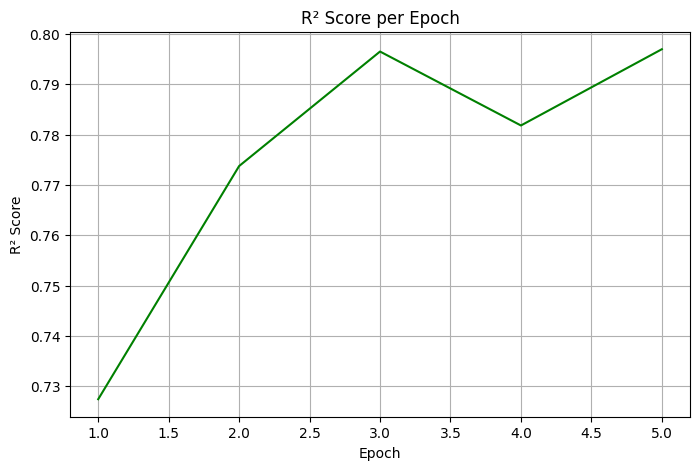

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("training_metrics.csv")

epochs = df["epoch"]

# 1. Train/Test Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, df["train_loss"], label="Train Loss")
plt.plot(epochs, df["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()

# 2. MAE / RMSE
plt.figure(figsize=(8, 5))
plt.plot(epochs, df["mae"], label="MAE")
plt.plot(epochs, df["rmse"], label="RMSE")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("MAE / RMSE per Epoch")
plt.legend()
plt.grid(True)
plt.show()

# 3. R² Score
plt.figure(figsize=(8, 5))
plt.plot(epochs, df["r2"], label="R²", color="green")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("R² Score per Epoch")
plt.grid(True)
plt.show()


Grad Cam

In [19]:
import torch
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor):
        self.model.zero_grad()
        output = self.model(input_tensor)
        output.backward()

        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = F.relu((weights * self.activations).sum(dim=1)).squeeze()

        cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam


In [20]:
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0)
    return img_tensor, np.array(img)

def show_gradcam_on_image(img, mask, alpha=0.5):
    img_resized = cv2.resize(img, (224, 224))
    if img_resized.dtype != np.uint8:
        img_resized = np.clip(img_resized, 0, 255).astype(np.uint8)

    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = heatmap * alpha + img_resized * (1 - alpha)
    overlay = np.clip(overlay, 0, 255).astype(np.uint8)

    plt.imshow(overlay)
    plt.axis('off')
    plt.title("Grad-CAM")
    plt.show()



In [21]:
import pandas as pd

df = pd.read_csv("aaf_age_labels.csv")

row = df.sample(1).iloc[0]
image_path = row["image_path"]
true_age = row["age"]

print(f"random image: {image_path} (actual age: {true_age})")


random image: /Users/geko/COSE471_data-science/AFF/aglined_faces/09362A29.jpg (actual age: 29)


In [22]:
import torch
from torchvision import models
import torch.nn as nn

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load("model2.pth", map_location=torch.device("cpu")))
model.eval()

target_layer = model.layer3[-1]
cam = GradCAM(model, target_layer)

image_path = "/Users/geko/COSE471_data-science/IMG_2562.JPG"  # ← Replace with your image path
input_tensor, original_img = preprocess_image(image_path)

cam_map = cam.generate(input_tensor.to(device))

true_age = 23  # ← Replace with actual age if known or load from file

with torch.no_grad():
    pred = model(input_tensor.to(device)).item()

print(f"Predicted Age: {pred:.2f} years")
print(f"Actual Age: {true_age} years")

threshold = 3  # tolerance (in years)

if pred < true_age - threshold:
    print("The person looks young for their age.")
elif pred > true_age + threshold:
    print("The person looks older than their age.")
else:
    print("The person looks appropriate for their age.")




/Users/geko/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/geko/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Predicted Age: 25.75 years
Actual Age: 23 years
The person looks appropriate for their age.


/Users/geko/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


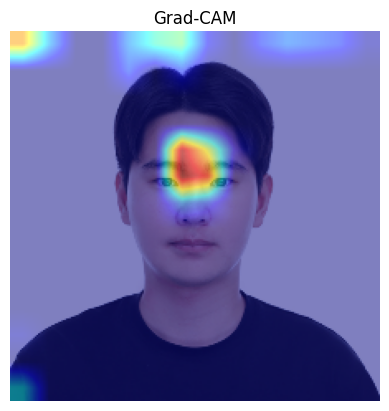

In [23]:
show_gradcam_on_image(original_img, cam_map)

In [ ]:
def create_region_masks(image_size=(224, 224)):
    masks = {}

    eye_mask = np.zeros(image_size, dtype=np.uint8)
    cv2.rectangle(eye_mask, (60, 70), (100, 100), 1, -1)
    cv2.rectangle(eye_mask, (124, 70), (164, 100), 1, -1)
    masks['eye'] = eye_mask

    forehead_mask = np.zeros(image_size, dtype=np.uint8)
    cv2.rectangle(forehead_mask, (70, 30), (154, 65), 1, -1)
    masks['forehead'] = forehead_mask

    mouth_mask = np.zeros(image_size, dtype=np.uint8)
    cv2.rectangle(mouth_mask, (85, 140), (140, 170), 1, -1)
    masks['mouth'] = mouth_mask

    return masks


In [26]:
def analyze_attention(cam_mask, region_masks):
    scores = {}
    for region, mask in region_masks.items():
        region_area = cam_mask[mask.astype(bool)]
        scores[region] = float(region_area.mean()) if region_area.size > 0 else 0.0
    return scores

cam_map = cam.generate(input_tensor.to(device))  # 224x224 np.float32 mask
region_masks = create_region_masks()
attention_scores = analyze_attention(cam_map, region_masks)

print(attention_scores)


{'eye': 0.09876938164234161, 'forehead': 0.031728345900774, 'mouth': 0.0}


SHAP

/var/folders/z9/rcj_df_s0w3_dmjx1r8sggmr0000gn/T/ipykernel_167/4125776173.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


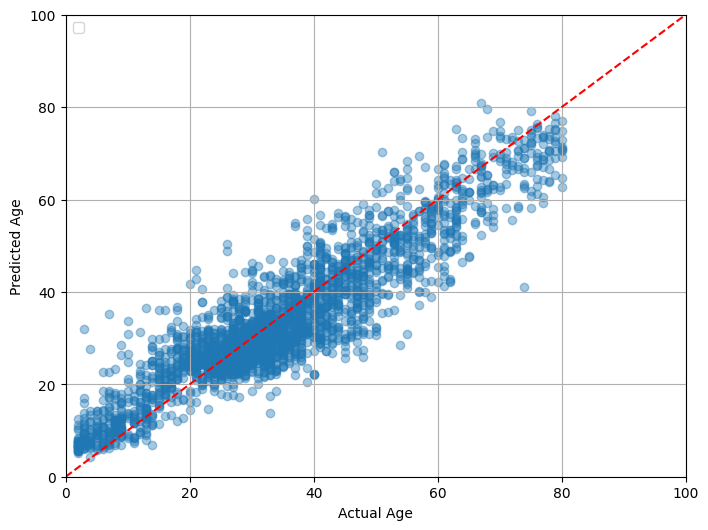

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_result["true_age"], df_result["pred_age"], alpha=0.4)
plt.plot([0, 100], [0, 100], color='red', linestyle='--')  # y=x 선
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.legend()
plt.grid(True)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.show()


In [30]:
import shap
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load("model2.pth", map_location=torch.device("cpu")))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def preprocess(image_path):
    img = Image.open(image_path).convert('RGB')
    original = np.array(img.resize((224, 224)))
    tensor = transform(img).unsqueeze(0)
    return tensor, original

image_path = "/Users/geko/COSE471_data-science/IMG_2562.JPG"
input_tensor, original_image = preprocess(image_path)

background = input_tensor.clone()  # 배경은 1개 이미지도 OK

e = shap.GradientExplainer((model, model.layer4), background)
shap_values = e.shap_values(input_tensor)
shap_map = shap_values[0, :, :, 0]  # (14, 14)
shap_map_resized = cv2.resize(shap_map, (224, 224))


/Users/geko/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/geko/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [32]:
region_scores = analyze_attention(shap_map_resized, region_masks)
print(region_scores)

{'eye': 7.83801105318047e-05, 'forehead': -0.00020967342167441707, 'mouth': -3.970943981771259e-05}


In [ ]:
Feature Explanation

In [228]:
def explain_all_shap_features(region_scores, threshold=0.00001):
    explanations = []
    for region, score in region_scores.items():
        if score > threshold:
            explanations.append(f"The {region} area contributes to looking older.")
        elif score < -threshold:
            explanations.append(f"The {region} area contributes to looking younger.")
    if not explanations:
        explanations.append("No significant feature influence detected.")
    return explanations

In [229]:
def top_k_match(shap_scores, cam_scores, k=1):
    shap_top = sorted(shap_scores.items(), key=lambda x: abs(x[1]), reverse=True)[:k]
    cam_top = sorted(cam_scores.items(), key=lambda x: x[1], reverse=True)[:k]

    shap_regions = {region for region, _ in shap_top}
    cam_regions = {region for region, _ in cam_top}

    overlap = shap_regions & cam_regions
    return overlap

In [230]:
def summarize_appearance_reason(region_scores, cam_scores, shap_threshold=0.00001):
    shap_explanations = explain_all_shap_features(region_scores, threshold=shap_threshold)
    cam_focus = max(cam_scores, key=cam_scores.get)
    cam_value = cam_scores[cam_focus]

    print("SHAP-based Feature Contributions:")
    for line in shap_explanations:
        print("-", line)

    print(f"\nGrad-CAM shows highest attention on the {cam_focus} region (score: {cam_value:.3f}).")
    
    matched = top_k_match(region_scores, attention_scores, k=2)
    if matched:
        print(f"SHAP and Grad-CAM both highlight: {', '.join(matched)}")
    else: 
        print("SHAP and Grad-CAM focus on different regions.")


In [231]:
summarize_appearance_reason(region_scores, attention_scores)

SHAP-based Feature Contributions:
- The eye area contributes to looking older.
- The forehead area contributes to looking younger.
- The mouth area contributes to looking younger.

Grad-CAM shows highest attention on the eye region (score: 0.099).
SHAP and Grad-CAM both highlight: eye, forehead
